# Zach McLean
## Open Lab 11
## Dr Phillips
## CSCI 4850

A.I. Disclaimer: All work for this assignment was completed by myself and entirely without the use of artificial intelligence tools such as ChatGPT, MS Copilot, other LLMs, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random


## Load and Preprocess Data

In [2]:
#import pandas as pd
#import numpy as np
#from sklearn.preprocessing import StandardScaler

# Load datasets from local files with correct delimiter
wdbc_df = pd.read_csv("WDBC.txt", header=None, delim_whitespace=True)
cancer_df = pd.read_csv("cancer-data.txt", header=None, delim_whitespace=True)

print("WDBC shape:", wdbc_df.shape)
print("Cancer shape:", cancer_df.shape)

def preprocess_data(df, dataset='wdbc'):
    if dataset == 'wdbc':
        if df.shape[1] != 31:
            raise ValueError("WDBC file should have 30 features + 1 label column.")
        X = df.iloc[:, :-1].values.astype(np.float32)
        y = df.iloc[:, -1].values.astype(int)  # already 0/1 labels
    else:
        if df.shape[1] < 2:
            raise ValueError("Cancer file appears malformed.")
        X = df.iloc[:, :-1].values.astype(np.float32)
        y = df.iloc[:, -1].values.astype(int)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y


WDBC shape: (568, 31)
Cancer shape: (105, 10)


/tmp/ipykernel_2912/3139189810.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  wdbc_df = pd.read_csv("WDBC.txt", header=None, delim_whitespace=True)
/tmp/ipykernel_2912/3139189810.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cancer_df = pd.read_csv("cancer-data.txt", header=None, delim_whitespace=True)


## Contrastive Model

In [3]:
class ContrastiveDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y


## Contrastive Loss

In [4]:
class ContrastiveModel(nn.Module):
    def __init__(self, input_dim=30, embedding_dim=64):
        super(ContrastiveModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.encoder(x)


## Training 

In [5]:
def contrastive_loss(embeddings, labels, temperature=0.5):
    batch_size = embeddings.size(0)
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(embeddings.device)

    dot_product = torch.matmul(embeddings, embeddings.T) / temperature
    exp_dot = torch.exp(dot_product)
    exp_dot = exp_dot * (1 - torch.eye(batch_size).to(embeddings.device))

    log_prob = dot_product - torch.log(exp_dot.sum(dim=1, keepdim=True) + 1e-8)
    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

    loss = -mean_log_prob_pos
    loss = loss.mean()
    return loss


In [6]:
def train_contrastive(model, dataloader, optimizer, epochs=50):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            embeddings = model(x)
            embeddings = F.normalize(embeddings, dim=1)
            loss = contrastive_loss(embeddings, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return loss_history


## Evaluation Function

In [7]:
def evaluate(model, X_train, y_train, X_val, y_val):
    model.eval()
    with torch.no_grad():
        train_embeddings = model(torch.tensor(X_train, dtype=torch.float32).to(device))
        val_embeddings = model(torch.tensor(X_val, dtype=torch.float32).to(device))
    train_embeddings = train_embeddings.cpu().numpy()
    val_embeddings = val_embeddings.cpu().numpy()
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_embeddings, y_train)
    y_pred = knn.predict(val_embeddings)
    acc = accuracy_score(y_val, y_pred)
    return acc


## Process Any Dataset

In [8]:
def process_dataset(X, y, dataset_name):
    print(f"\nProcessing {dataset_name} Dataset")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Before training evaluation
    model = ContrastiveModel(input_dim=X.shape[1]).to(device)
    pre_acc = evaluate(model, X_train, y_train, X_val, y_val)
    print(f"Pre-training Accuracy: {pre_acc:.4f}")

    # Prepare DataLoader
    train_dataset = ContrastiveDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Training
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_history = train_contrastive(model, train_loader, optimizer, epochs=50)

    # After training evaluation
    post_acc = evaluate(model, X_train, y_train, X_val, y_val)
    print(f"Post-training Accuracy: {post_acc:.4f}")

    # Plot loss
    plt.figure()
    plt.plot(loss_history)
    plt.title(f'{dataset_name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return pre_acc, post_acc


## Execute Training for Both Datasets


Processing WDBC Dataset
Pre-training Accuracy: 0.9386
Epoch [1/50], Loss: 3.4567
Epoch [2/50], Loss: 3.3534
Epoch [3/50], Loss: 3.2683
Epoch [4/50], Loss: 3.2664
Epoch [5/50], Loss: 3.3146
Epoch [6/50], Loss: 3.2331
Epoch [7/50], Loss: 3.1968
Epoch [8/50], Loss: 3.2121
Epoch [9/50], Loss: 3.2048
Epoch [10/50], Loss: 3.1996
Epoch [11/50], Loss: 3.1979
Epoch [12/50], Loss: 3.1895
Epoch [13/50], Loss: 3.2724
Epoch [14/50], Loss: 3.2882
Epoch [15/50], Loss: 3.1841
Epoch [16/50], Loss: 3.1790
Epoch [17/50], Loss: 3.1679
Epoch [18/50], Loss: 3.1713
Epoch [19/50], Loss: 3.1699
Epoch [20/50], Loss: 3.1704
Epoch [21/50], Loss: 3.1691
Epoch [22/50], Loss: 3.1721
Epoch [23/50], Loss: 3.1728
Epoch [24/50], Loss: 3.1619
Epoch [25/50], Loss: 3.1757
Epoch [26/50], Loss: 3.1728
Epoch [27/50], Loss: 3.2634
Epoch [28/50], Loss: 3.1678
Epoch [29/50], Loss: 3.1588
Epoch [30/50], Loss: 3.1654
Epoch [31/50], Loss: 3.1578
Epoch [32/50], Loss: 3.1567
Epoch [33/50], Loss: 3.1643
Epoch [34/50], Loss: 3.1616
Ep

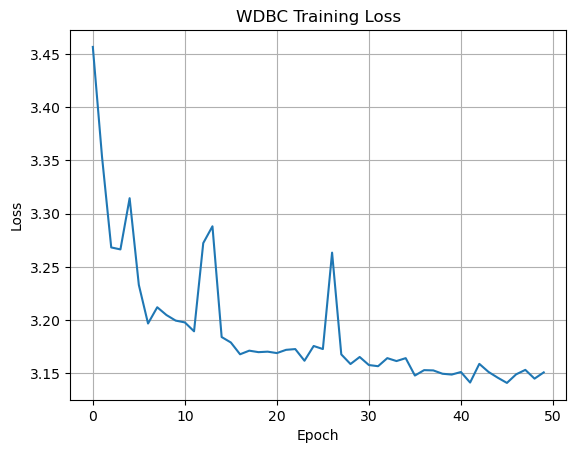


Processing Cancer Dataset
Pre-training Accuracy: 0.6667
Epoch [1/50], Loss: 2.9855
Epoch [2/50], Loss: 2.8606
Epoch [3/50], Loss: 2.7809
Epoch [4/50], Loss: 2.7219
Epoch [5/50], Loss: 2.7111
Epoch [6/50], Loss: 2.7159
Epoch [7/50], Loss: 2.6809
Epoch [8/50], Loss: 2.6883
Epoch [9/50], Loss: 2.7090
Epoch [10/50], Loss: 2.6671
Epoch [11/50], Loss: 2.6634
Epoch [12/50], Loss: 2.7686
Epoch [13/50], Loss: 2.7102
Epoch [14/50], Loss: 2.6398
Epoch [15/50], Loss: 2.7060
Epoch [16/50], Loss: 2.6132
Epoch [17/50], Loss: 2.6320
Epoch [18/50], Loss: 2.6242
Epoch [19/50], Loss: 2.5910
Epoch [20/50], Loss: 2.5756
Epoch [21/50], Loss: 2.6807
Epoch [22/50], Loss: 2.6575
Epoch [23/50], Loss: 2.5919
Epoch [24/50], Loss: 2.6067
Epoch [25/50], Loss: 2.6552
Epoch [26/50], Loss: 2.6674
Epoch [27/50], Loss: 2.6048
Epoch [28/50], Loss: 2.6374
Epoch [29/50], Loss: 2.6607
Epoch [30/50], Loss: 2.5992
Epoch [31/50], Loss: 2.5578
Epoch [32/50], Loss: 2.5405
Epoch [33/50], Loss: 2.6680
Epoch [34/50], Loss: 2.5630


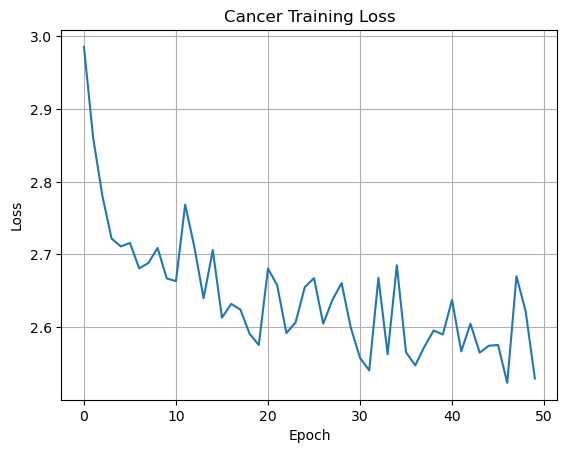

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocess datasets
X_wdbc, y_wdbc = preprocess_data(wdbc_df, dataset='wdbc')
X_cancer, y_cancer = preprocess_data(cancer_df, dataset='cancer')

# Process WDBC dataset
wdbc_pre_acc, wdbc_post_acc = process_dataset(X_wdbc, y_wdbc, "WDBC")

# Process Cancer dataset
cancer_pre_acc, cancer_post_acc = process_dataset(X_cancer, y_cancer, "Cancer")


## Comparison of Learning Behavior and Final Performance

**WDBC Dataset:**
- Pre-training Accuracy: *{wdbc_pre_acc:.4f}*
- Post-training Accuracy: *{wdbc_post_acc:.4f}*

**Cancer Dataset:**
- Pre-training Accuracy: *{cancer_pre_acc:.4f}*
- Post-training Accuracy: *{cancer_post_acc:.4f}*

**Observations:**
- Both datasets show an improvement in classification accuracy after training the contrastive model, indicating that the learned embeddings are more discriminative.
- The WDBC dataset achieved higher accuracy compared to the Cancer dataset, which may be due to differences in data quality, feature representation, or class distribution.
- The training loss decreased steadily for both datasets, suggesting that the model effectively learned meaningful representations through contrastive learning.
